<a href="https://colab.research.google.com/github/victorviro/Machine-Learning-Python/blob/master/Machine_Learning_Interpretability_with_InterpretML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

1. [Importance of interpretability](#1)
2. [Categorization of explanations](#2)
    1. [Local vs Global](#2.1)
    2. [Self-explaning vs Post-hoc](#2.2)
    3. [Model-specific vs model-agnostic](#2.3)
3. [Dataset](#3)
4. [Model](#4)
5. [Methods](#5)
    1. [Feature importance](#5.1)
    2. [Permutation feature importance](#5.2)
    3. [PDP and ICE](#5.3)
        1. [Partial dependence plot (PDP)](#5.3.1)
        2. [Individual conditional expectation (ICE)](#5.3.2)
    4. [Surrogate model](#5.4)
        1. [Global surrogate model](#5.4.1)
        1. [Local surrogate model](#5.4.2)
    5. [SHAP](#5.5)

4. [References](#6)

# Importance of Interpretability <a name="1"></a>

As machine learning has matured into wide-spread adoption, building models that users can understand is becoming increasingly important. This can easily be observed in high-risk applications such as healthcare or finance environments. Interpretability is also important in generally applied machine learning problems such as model debugging ("Why did my model make this mistake?"), regulatory compliance ("Does my model satisfy legal requirements"?), human-computer interaction ("How can I understand and trust the model's decisions?"), and fairness detection ("Does my model discriminate?").

Until a little time ago, it was a tradeoff between performance and interpretability, that is we had to choose between an interpretable model admitting a lower performance (*glassbox* model) like a decision tree or rule-based models, and a more complex model with higher performance and lower interpretability (*blackbox* model) like a random forest or a deep neural network. However, in the last few years, some techniques, strategies, and packages have been introduced that allow us to interpret blackbox models.

# Categorization of explanations <a name="2"></a>

Explanations are often categorized along with two main aspects. 

- The first distinguishes whether the explanation is for an individual prediction (*local*) or the model’s prediction process as a whole (*global*). 

- The second differentiates between the explanation
emerging directly from the prediction process (*self-explaining*) versus requiring post-processing (*post-hoc*). 

![](https://i.ibb.co/4KzXKYN/Categories-AI-explanations.png)

## Local vs Global <a name="2.1"></a>

- A *local* explanation provides information or justification for the model’s prediction on a specific input.

- A *global* explanation provides similar justification by revealing how the model’s predictive process works generally, independently of any particular input.

##  Self-Explaining vs Post-Hoc <a name="2.2"></a>

Explanations differ on whether they arise as part of the prediction process, or whether their generation requires post-processing following the model making a prediction. 

- A *self-explaining* approach, which may also be referred to as directly interpretable, generates the explanation at the same time as the prediction, using information emitted by the model as a result of the process of making that prediction. Decision trees, linear regression models, and rule-based models are examples of global self-explaining models, while feature saliency approaches such as attention are examples of local self-explaining models.

- In contrast, a *post-hoc* approach requires that an additional operation is performed after the predictions are made. Permutation feature importance is, for example, a global post hoc interpretation method. [LIME](https://arxiv.org/abs/1602.04938) is an example of producing a local explanation using a surrogate model applied following the predictor’s operation. 

## Model-specific vs model-agnostic <a name="2.3"></a>

- *Model-specific* interpretation tools are limited to specific model classes. The interpretation of regression weights in a linear model is a model-specific interpretation. Tools that only work for the interpretation of e.g. neural networks are model-specific. 

- *Model-agnostic* tools can be used on any machine learning model and are applied after the model has been trained (post hoc). These agnostic methods usually work by analyzing feature input and output pairs. By definition, these methods cannot have access to model internals such as weights or structural information.

# Dataset <a name="3"></a>

The data contains anonymous information of people such as age, occupation, education, working class, etc. The goal is to train a binary classifier to predict the income which has two possible values `">50K"` and `"<50K"`. An additional description of the dataset is available [here](https://archive.ics.uci.edu/ml/datasets/Adult).

In [ ]:
!pip install -U scikit-learn

In [ ]:
import pandas as pd

# Load the dataset in pandas DataFrame
dataset = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None
)
# Set the name of the variables in the dataset
dataset.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
train_cols = dataset.columns[0:-1]
label = dataset.columns[-1]

In [ ]:
# Get the features to train the model
X = dataset[train_cols].drop(["Education","NativeCountry"], axis=1)
# Get the target variable
y = dataset[label]
class_labels = list(y.unique()) 
# Convert the target categorical variable to a binary variable
y = y.apply(lambda x: 0 if x == class_labels[0] else 1) # 1 if >50k
print(X.shape)
X.head()

(32561, 12)


,Age,WorkClass,fnlwgt,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40


In [ ]:
from sklearn.model_selection import train_test_split

# Transform categorical features to one-hot encoding
X_enc = pd.get_dummies(X, prefix_sep='.')
feature_names = list(X_enc.columns)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, 
                                                    random_state=1)

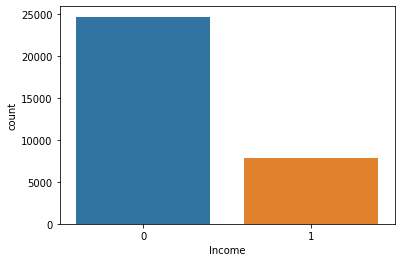

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check unbalanced dataset
sns.countplot(x=y)

# Model <a name="4"></a>

We define and train a random forest classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rf.fit(X_train, y_train)
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.860


# Methods <a name="5"></a>

First, the easiest way to achieve interpretability is to use only a subset of algorithms that create interpretable models. Linear regression, logistic regression, and the decision tree are commonly used interpretable models.

Explainability techniques differ in the mechanisms they adopt to generate the raw mathematical justifications that lead to the final explanation.

## Feature importance <a name="5.1"></a>

The main idea is to derive a global explanation by investigating the importance scores of different features used to output the final prediction. It allows us to know what features have the biggest impact on predictions (more important features have a bigger impact). For a classical linear model, the standardized regression coefficient is a feature importance measure.

Scikit-Learn implements by default an impurity-based feature importance method in tree-based models.

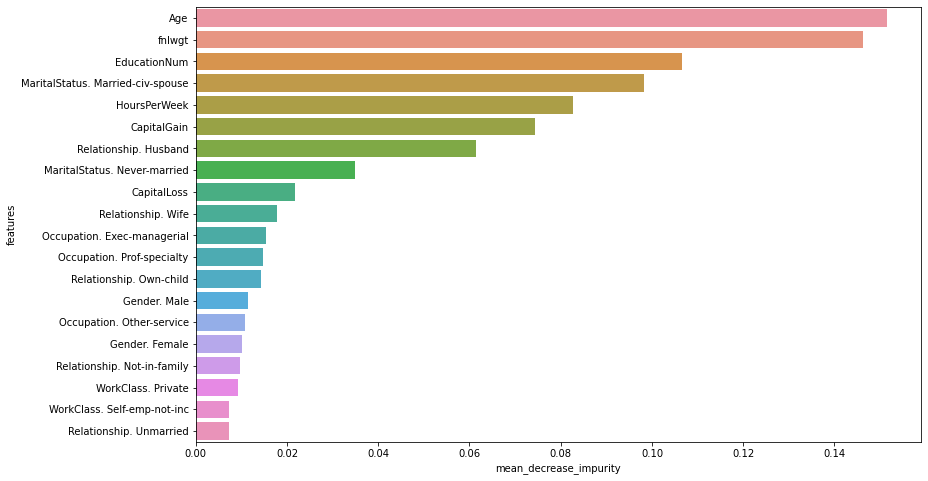

In [ ]:
feature_importance_dict = {
    "features": feature_names, 
    "mean_decrease_impurity": rf.feature_importances_
}
feature_importance = pd.DataFrame(feature_importance_dict).sort_values(
    'mean_decrease_impurity', ascending=False)

# Plot importance of the features
plt.figure(figsize=(13, 8))
sns.barplot(data=feature_importance[:20], x='mean_decrease_impurity', y='features')

Impurity-based feature importance can inflate the importance of numerical features. Furthermore, the impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.

Permutation Importance as an alternative that can mitigate those limitations. Moreover, it can be used for any model (model-agnostic).

## Permutation Feature Importance <a name="5.2"></a>

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. A feature is "important" if shuffling its values increases the model error because in this case, the model relied on the feature for the prediction. A feature is "unimportant" if shuffling its values leaves the model error unchanged because in this case, the model ignored the feature for the prediction.

The permutation feature importance algorithm follows the next steps:

- Estimate the original model error $e_{\text{orig}} = L(\boldsymbol{y}, f(\boldsymbol{X}))$. $f$ is the trained model, $\boldsymbol{X}$ is the feature matrix, $\boldsymbol{y}$ is the target vector, and $L$ is the error measure (e.g. mean squared error for a regression task).

- For each feature $j = 1,...,p$ :

 - Generate feature matrix $\boldsymbol{X}_{\text{perm}}$ by permuting feature $j$ in the data $\boldsymbol{X}$. This breaks the association between feature $j$ and true outcome $\boldsymbol{y}$.
 - Estimate error $e_{\text{perm}} = L(\boldsymbol{y}, f(\boldsymbol{X}_{\text{perm}}))$ based on the predictions of the permuted data.

 - Calculate permutation feature importance $\text{FI}_j=\frac{e_{\text{perm}}}{e_{\text{orig}}}$. Alternatively, the difference can be used $\text{FI}_j=e_{\text{perm}}-e_{\text{orig}}$. A positive aspect of using the error ratio instead of the error difference is that the feature importance measurements are comparable across different problems.

- Sort features by descending $\text{FI}$.

This technique benefits from being **model agnostic** and can be calculated many times with different permutations of the feature.

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test,
                                n_repeats=30,
                                random_state=0)

In [ ]:
permutation_importance_df = pd.DataFrame(result.importances.T, 
                                         columns=feature_names)
# Get the indices of features with more importance weighted
sorted_idx = list(result.importances_mean.argsort())
sorted_idx.reverse()

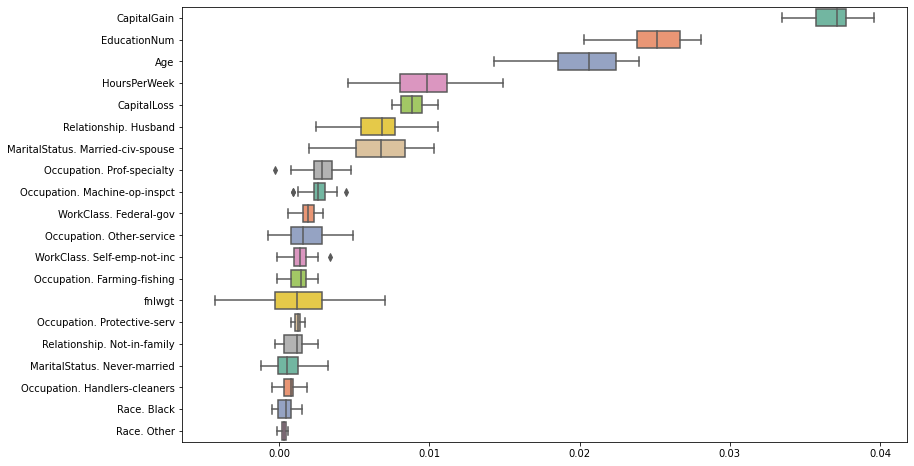

In [ ]:
# Plot importance of the 20 more important features 
plt.figure(figsize=(13, 8))
sns.boxplot(data=permutation_importance_df.iloc[:,sorted_idx[:20]], 
            orient="h", palette="Set2")

The feature with the highest importance was `CapitalGain`.

Permutation importances can be computed either on the training set or on a held-out testing or validation set. Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.

**Advantages**:

- Nice interpretation: Feature importance is the increase in model error when the feature's information is destroyed.

- Feature importance provides a highly compressed, **global insight** into the model's behavior.

-  The importance measure takes into account both the main feature effect and all the interaction effects with other features on model performance since by permuting the feature, the interaction effects with other features are also destroyed. This is also a disadvantage because the importance of the interaction between two features is included in the importance measurements of both features. This means that the feature importances do not add up to the total drop in performance, but the sum is larger. Only if there is no interaction between the features, as in a linear model, the importances add up approximately.

- Permutation feature importance does not require retraining the model.

**Disadvantages**

- It is unclear whether we should use training or test data to compute the feature importance.

- We need access to the true outcome. 

- The permutation feature importance depends on shuffling the feature, which adds randomness to the measurement. When the permutation is repeated, the results might vary. Repeating the permutation and averaging the importance measures over repetitions stabilizes the measure, but increases the time of computation.

- If features are **correlated**, the permutation feature importance can be **biased by unrealistic data instances**. The permutation of features produces unlikely data instances when two or more features are correlated. When they are positively correlated (like height and weight of a person) and we shuffle one of the features, we create new instances that are unlikely or even physically impossible (2-meter person weighing 30 kg for example), yet we use these new instances to measure the importance. In other words, for the permutation feature importance of a correlated feature, we consider how much the model performance decreases when we exchange the feature with values we would never observe in reality. We must check if the features are strongly correlated and be careful about the interpretation of the feature importance if they are.

 Moreover, adding a correlated feature can decrease the importance of the associated feature by splitting the importance between both features. Suppose we predict the probability of rain and use the temperature at 8:00 AM of the day before as a feature along with other uncorrelated features. We train a random forest and the temperature is the most important feature. Now imagine we additionally include the temperature at 9:00 AM as a feature that is strongly correlated with the temperature at 8:00 AM. We train a random forest with the two temperature features and the uncorrelated features. The two temperature features together have a bit more importance than the single temperature feature before, but instead of being at the top of the list of important features, each temperature is now somewhere in the middle. By introducing a correlated feature, we kicked the most important feature from the top of the importance ladder to mediocrity. It simply reflects the behavior of the underlying machine learning model (the 8:00 AM temperature has simply become less important because the model can now rely on the 9:00 AM measurement as well). But, it makes the interpretation of the feature importance considerably more difficult. Even though the importance values might make sense at the level of model behavior, it is confusing if we have correlated features.

## PDP and ICE <a name="5.3"></a>

The techniques we reviewed until now looked at the relative importance of different features. Now let’s move slightly in a different direction and look at two model agnostic techniques, which explore how a particular feature interacts with the target variable.

### Partial dependence plot (PDP) <a name="5.3.1"></a>

The *partial dependence plot* (PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a model. It can show whether the relationship between the target and a feature is linear, monotonic or more complex. It is estimated by calculating averages in the training data. It is a global method since it considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

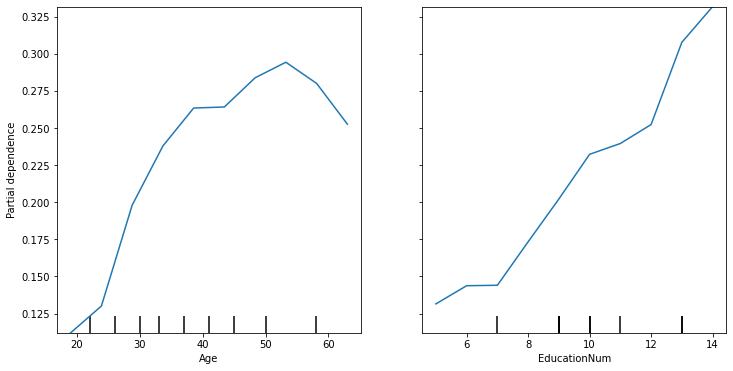

In [ ]:
from sklearn.inspection import plot_partial_dependence
features = [0,2]
fig, ax = plt.subplots(figsize=(12, 6))
plot_partial_dependence(rf, X_train, features, grid_resolution=10, ax=ax) 

For `Age`, the PDP shows that the probability of people gain more than 50k increases until 55 years and decreases after. For `EducationNum`, the higher level of education the higher the probability.

We can also visualize the partial dependence of two features at once:

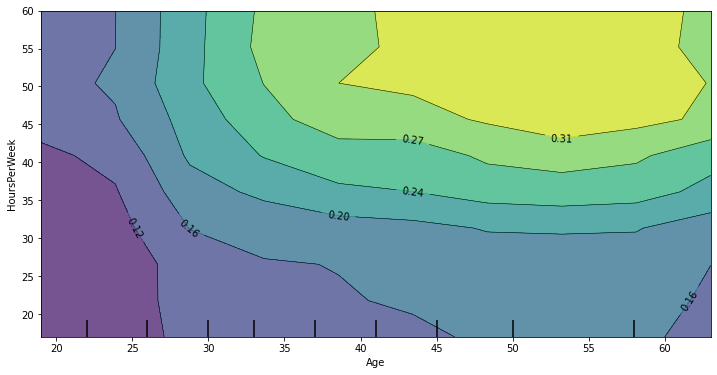

In [ ]:
features = [(0,5)]
fig, ax = plt.subplots(figsize=(12, 6))
plot_partial_dependence(rf, X_train, features, grid_resolution=10, ax=ax) 

PDP of income probability and the interaction of age and number of hours worked per week. For ages below 25, people who work less than 40 hours per week have a lower probability to gain more than 50k. For ages above 40, people who work more than 45 hours per week have a higher probability. But we must be careful when drawing conclusions: This might just be a correlation and not causal!

**Advantages**

- The computation of partial dependence plots is intuitive: The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value.

- Partial dependence plots are easy to implement.

- If the feature for which we computed the PDP is not correlated with the other features, then the PDPs perfectly represent how the feature influences the prediction on average. The partial dependence plot shows how the average prediction in our dataset changes when the $j$-th feature is changed. It is more complicated when features are correlated.


**Disadvantages**

- The realistic maximum number of features in a partial dependence function is two (for our inability to imagine more than 3 dimensions).

- Some PD plots do not show the feature distribution, which can be misleading, because we might overinterpret regions with almost no data. It can be solved by showing a rug (indicators for data points on the x-axis) or a histogram.

- The assumption of independence is the biggest issue with PD plots. It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features.

- Heterogeneous effects might be hidden because PD plots only show the average marginal effects. Suppose that for a feature, half our data points have a positive relationship with the prediction (the larger the feature value the larger the prediction), and the other half has a negative association. The PD curve could be a horizontal line since the effects of both halves of the dataset could cancel each other out. We then conclude that the feature has no effect on the prediction. By plotting the individual conditional expectation (ICE) curves instead of the aggregated line, we can uncover heterogeneous effects.

### Individual Conditional Expectation (ICE) <a name="5.3.2"></a>

The PDP for the average effect of a feature is a global method because it does not focus on specific instances but on an overall average. The equivalent to a PDP for individual data instances is called **individual conditional expectation (ICE) plot**. An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. A PDP is the average of the lines of an ICE plot. The values for a line can be computed by keeping all other features the same, creating variants of this instance by replacing the feature's value with values from a grid, and making predictions with the black box model for these newly created instances. The result is a set of points for an instance with the feature value from the grid and the respective predictions.

PDP works well if the interactions between the features for which the PDP is calculated and the other features are weak. In the case of interactions, the ICE plot will provide much more insight.

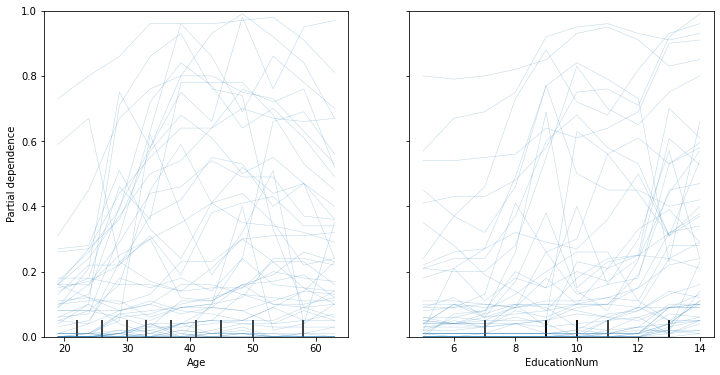

In [ ]:
features = [0,2]
fig, ax = plt.subplots(figsize=(12, 6))
fig = plot_partial_dependence(rf, X_train, features, 
                              grid_resolution=10,
                              subsample=50,
                              kind='individual',
                              ax=ax) 

Each line represents one person. For `Age`, most curves do not follow the same course, so there is a clue of interactions. For most people, there is an increase in probability with a higher level of education.

**Advantages**

- ICE curves are even more intuitive to understand than PDP. One line represents the predictions for one instance if we vary the feature of interest.

- Unlike partial dependence plots, ICE curves can uncover heterogeneous relationships.


**Disadvantages**

- ICE curves can only display one feature meaningfully.

- ICE curves suffer from the same problem as PDPs: If the feature of interest is correlated with the other features, then some points in the lines might be invalid data points according to the joint feature distribution.

- If many ICE curves are drawn, the plot can become overcrowded. The solution is to draw only a sample of the lines.

- In ICE plots it might not be easy to see the average. The solution is to combine individual ICE curves with the PDP.

## Surrogate model <a name="5.4"></a>

Model predictions are explained by learning a second model (the *surrogate* model), usually a more explainable model, as a proxy. Surrogate model-based approaches are model-agnostic and can be used to achieve either local or global explanations. However, the learned surrogate models and the original models may have completely different mechanisms to make predictions, leading to concerns about the fidelity of surrogate model-based approaches.

### Global surrogate model <a name="5.4.1"></a>

A global surrogate model is an interpretable model that is trained to approximate the predictions of a black box model as accurately as possible and to be interpretable at the same time. We can draw conclusions about the black-box model by interpreting the surrogate model. 

Training a surrogate model is a model-agnostic method since it does not require any information about the inner workings of the black-box model, only access to data and the prediction function is necessary.

To obtain a surrogate model, generally, we perform the next steps:

- Select a dataset. 

- For the selected dataset, get the predictions of the black-box model.

- Select an interpretable model type (linear model, decision tree, ...).

- Train the interpretable model on the dataset and its predictions.

- Measure how well the surrogate model replicates the predictions of the black-box model.

- Interpret the surrogate model.

**Advantages**

- The surrogate model method is flexible: Any interpretable model can be used. This also means that we can exchange not only the interpretable model but also the underlying black-box model.

It is easy to implement, but also easy to explain to people not familiar with data science or machine learning.

- With the R-squared measure, we can easily measure how good our surrogate models are in approximating the black box predictions.


**Disadvantages**

- We have to be aware that you draw conclusions about the model and not about the data, since the surrogate model never sees the real outcome.

- It is not clear what the best cut-off for R-squared is in order to be confident that the surrogate model is close enough to the black-box model.

- It could happen that the interpretable model is very close for one subset of the dataset but widely divergent for another subset. In this case, the interpretation for the simple model would not be equally good for all data points.

- The interpretable model we choose as a surrogate comes with all its advantages and disadvantages.

### Local surrogate model <a name="5.4.2"></a>

Local surrogate models are interpretable models that are used to explain individual predictions of black-box machine learning models. *Local interpretable model-agnostic explanations* ([LIME](https://arxiv.org/abs/1602.04938)) is a paper in which the authors propose a concrete implementation of local surrogate models, which learns surrogate models using an operation called *input perturbation*. 

The idea is quite intuitive. First, we forget about the training data and suppose we only have the black-box model where we can input data points and get the predictions of the model. Our goal is to understand why the machine learning model made a certain prediction. LIME tests what happens to the predictions when we give variations of our data into the machine learning model. LIME generates a new dataset consisting of permuted samples and the corresponding predictions of the black-box model. On this new dataset LIME then trains an interpretable model, which is weighted by the proximity of the sampled instances to the instance of interest. The interpretable model can be, for example, Lasso or a decision tree. The learned model should be a good approximation of the machine learning model predictions locally, but it does not have to be a good global approximation.

The steps for training local surrogate models:

- Select your instance of interest for which you want to have an explanation of its black box prediction.

- Perturb your dataset and get the black box predictions for these new points.

- Weight the new samples according to their proximity to the instance of interest.

- Train a weighted, interpretable model on the dataset with the variations.

- Explain the prediction by interpreting the local model.

How do we get the variations of the data? This depends on the type of data, which can be either text, image, or tabular data. 

- In the case of tabular data, LIME creates new samples by perturbing each feature individually, drawing from a normal distribution with mean and standard deviation taken from the feature. Then a locally surrogate model is trained weighting the samples according to their proximity to the instance of interest.

- For text, new texts are created by randomly removing words from the original text

- For images, variations of the images are created by segmenting the image into "superpixels" and turning superpixels off or on. Superpixels are interconnected pixels with similar colors and can be turned off by replacing each pixel with a user-defined color such as gray. 

Some tutorials can be found on the GitHub [repository](https://github.com/marcotcr/lime) of the package. Instead, we will use [InterpretML](https://github.com/interpretml/interpret),  an open-source Python package that provides machine learning interpretability algorithms. This is further supported with interactive visualizations and a built-in dashboard designed for interpretability algorithm comparison.

In [ ]:
!pip install interpret

In [ ]:
from interpret import show
from interpret.blackbox import LimeTabular
from interpret import show

In [ ]:
# Select the prediction function and a dataset
lime = LimeTabular(predict_fn=rf.predict_proba, data=X_train)

# Select the 5 first instances in the test set to explain
lime_local = lime.explain_local(X_test[:5], y_test[:5], name='LIME')

show(lime_local)

/usr/local/lib/python3.6/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


**Advantages**

- Even if we replace the underlying machine learning model, we can still use the same local, interpretable model for the explanation.

- LIME is one of the few methods that works for tabular data, text, and images.

- When using Lasso or short trees, the resulting explanations are short and possibly contrastive ("How would the prediction have been if the input had been different?"). 


**Disadvantages**

- The correct definition of the neighborhood is a very big, unsolved problem when using LIME with tabular data.

- Data points are sampled from a Gaussian distribution, ignoring the correlation between features. This can lead to unlikely data points which can then be used to learn local explanation models.

- Another problem is the instability of the explanations. If we repeat the sampling process, then the explanations that come out can be different, hindering to trust the explanations.

## SHAP <a name="5.5"></a>

SHapley Additive exPlanations ([SHAP](https://github.com/slundberg/shap)) is a method to explain individual predictions. SHAP is based on the game theoretically optimal *Shapley Values*. A prediction can be explained by assuming that each feature value of the instance is a "player" in a game where the prediction is the payout. Shapley values, a method from coalitional game theory, tells us how to fairly distribute the "payout" (= the prediction) among the features.


A further explanation is available [here](https://christophm.github.io/interpretable-ml-book/shap.html).

**Advantages**

- SHAP has a solid theoretical foundation in game theory. 

- The prediction is fairly distributed among the feature values. 

- The Shapley value allows contrastive explanations. Instead of comparing a prediction to the average prediction of the entire dataset, we could compare it to a subset or even to a single data point.

- The fast computation makes it possible to compute the many Shapley values needed for the global model interpretations. The global interpretation methods include feature importance, feature dependence, interactions, clustering, and summary plots.

- With SHAP, global interpretations are consistent with the local explanations, since the Shapley values are the "atomic unit" of the global interpretations.


**Disadvantages**

- We need access to the data if we want to calculate the Shapley value for a new data instance.

- Like many other permutation-based interpretation methods, KernelSHAP method suffers from the inclusion of unrealistic data instances when features are correlated. TreeSHAP solves this problem by explicitly modeling the conditional expected prediction.

# References <a name="6"></a>

- [InterpretML Github](https://github.com/interpretml/interpret), [paper](https://arxiv.org/abs/1909.09223)


- [LIME Github](https://github.com/marcotcr/lime), [paper](https://arxiv.org/abs/1602.04938)

- [SHAP](https://github.com/slundberg/shap)

- [Interpretable ML book article](https://christophm.github.io/interpretable-ml-book/)


- [kdnuggets Interpretability of blakbox models](https://www.kdnuggets.com/2019/12/interpretability-black-box-part-2.html)

- [One Explanation Does Not Fit All: A Toolkit and Taxonomy of AI Explainability Techniques](https://arxiv.org/abs/1909.03012) 

- [Explainable Artificial Intelligence (XAI): Concepts, Taxonomies, Opportunities and Challenges toward Responsible AI](https://arxiv.org/abs/1910.10045)

- [Opportunities and Challenges in Explainable Artificial Intelligence (XAI): A Survey](https://arxiv.org/abs/2006.11371)